Alright, let's proceed step by step:

1. **Data Exploration**: We'll start by loading the data and performing some initial exploration to understand its structure and the nature of the variables.
2. **Data Cleaning**: If necessary, we'll clean the dataset, handle missing values, and convert data types.
3. **Data Visualization**: We'll visualize the data to get some insights about relationships between variables.
4. **Model Building & Evaluation**: 
   - For highest accuracy: We'll use several machine learning models and evaluate their performance.
   - For fewest variables: We'll use techniques such as feature importance or recursive feature elimination to identify a minimal set of features that can still provide reasonable prediction accuracy.

Let's start with the first step: **Data Exploration**.

In [2]:
import pandas as pd

# Load the data
data = pd.read_csv('all_data_heat_disease.csv')

# Display the first few rows of the dataset to understand its structure
data.head()


,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,location
0,0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,1
1,1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,1
4,4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1


The dataset contains an "Unnamed: 0" column, which seems to be an unnecessary index column. We'll remove this column during the data cleaning process.

Before we proceed to data cleaning, let's:

1. Check the data types of the columns.
2. Identify any missing values.

In [3]:
# Check data types of the columns
data_types = data.dtypes

# Check for missing values in each column
missing_values = data.isnull().sum()

data_types, missing_values

(Unnamed: 0      int64
 age           float64
 sex           float64
 cp            float64
 trestbps       object
 chol           object
 fbs            object
 restecg        object
 thalach        object
 exang          object
 oldpeak        object
 slope          object
 ca             object
 thal           object
 num             int64
 location        int64
 dtype: object,
 Unnamed: 0    0
 age           0
 sex           0
 cp            0
 trestbps      0
 chol          0
 fbs           0
 restecg       0
 thalach       0
 exang         0
 oldpeak       0
 slope         0
 ca            0
 thal          0
 num           0
 location      0
 dtype: int64)

Observations:

1. Several columns that should be numeric (e.g., `trestbps`, `chol`, `fbs`, etc.) are of type `object`. This suggests that there might be some non-numeric entries in these columns.
2. There are no missing values in the dataset, which is good.

Next steps:

1. Let's further investigate the `object` type columns to see if they have any non-numeric entries.
2. We'll then convert these columns to the appropriate numeric data type.
3. We'll also drop the unnecessary "Unnamed: 0" column.


In [4]:
# Investigate unique values in object type columns to identify non-numeric entries
object_cols = data.columns[data.dtypes == 'object']

non_numeric_entries = {}
for col in object_cols:
    try:
        # Convert column to float to see if any error occurs
        data[col].astype(float)
    except ValueError:
        # If error occurs, get the non-numeric values in that column
        non_numeric_entries[col] = data[~data[col].apply(lambda x: str(x).replace('.', '', 1).isdigit())][col].unique()

non_numeric_entries


{'trestbps': array(['?', '-9'], dtype=object),
 'chol': array(['?', '-9'], dtype=object),
 'fbs': array(['?', '-9'], dtype=object),
 'restecg': array(['?', '-9'], dtype=object),
 'thalach': array(['?', '-9'], dtype=object),
 'exang': array(['?', '-9'], dtype=object),
 'oldpeak': array(['?', '-1.1', '-1.5', '-.1', '-2.6', '-.7', '-2', '-1', '-.8',
        '-.5', '-.9', '-0.5'], dtype=object),
 'slope': array(['?', '-9'], dtype=object),
 'ca': array(['?', '-9'], dtype=object),
 'thal': array(['?', '-9'], dtype=object)}

It appears that several columns contain non-numeric entries such as '?' and negative values like '-9'. These entries likely represent missing or undefined data.

To handle this:

1. We'll replace '?' and '-9' with `NaN` for these columns.
2. Convert the columns to their appropriate numeric data type.
3. Address the NaN values. Given the nature of the dataset (medical data), it might be better to impute the missing values rather than simply dropping them, but we'll first analyze how many missing values there are.
4. Drop the "Unnamed: 0" column.

Let's proceed with these steps.

In [5]:
import numpy as np

# Replace '?' and '-9' with NaN
data.replace(['?', '-9'], np.nan, inplace=True)

# Convert object columns to appropriate numeric data type
for col in object_cols:
    data[col] = data[col].astype(float)

# Drop the "Unnamed: 0" column
data.drop(columns=['Unnamed: 0'], inplace=True)

# Check for the total number of missing values again
missing_values_updated = data.isnull().sum()

missing_values_updated


age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       309
ca          610
thal        486
num           0
location      0
dtype: int64

We can observe that several columns have missing values, with `ca` and `thal` having the highest number of missing entries.

Given the nature of the dataset, imputing the missing values might be a good approach. We have several options for imputation:

1. **Mean/median imputation**: This involves replacing missing values with the mean or median of the column. It's straightforward but might not always be the best representation, especially if the data isn't normally distributed.
2. **Mode imputation**: This involves replacing missing values with the mode (most frequently occurring value) of the column. Useful for categorical data.
3. **Model-based imputation**: This involves using models like KNN or regression to predict and replace missing values. It can be more accurate but also more computationally expensive.

Given the number of missing values, we'll initially try mean/median imputation for continuous variables and mode imputation for categorical ones. Let's proceed with this approach.


In [6]:
# Impute missing values

# Columns for mean imputation
mean_cols = ['trestbps', 'chol', 'thalach', 'oldpeak']

# Columns for median imputation (since they should be discrete values)
median_cols = ['ca']

# Columns for mode imputation
mode_cols = ['fbs', 'restecg', 'exang', 'slope', 'thal']

# Perform imputation
for col in mean_cols:
    data[col].fillna(data[col].mean(), inplace=True)

for col in median_cols:
    data[col].fillna(data[col].median(), inplace=True)

for col in mode_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Check if there are any remaining missing values
remaining_missing_values = data.isnull().sum()

remaining_missing_values

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
location    0
dtype: int64

All missing values have been successfully imputed.

Next, let's move on to **Data Visualization** to understand the distribution of data and relationships between variables. This will give us insights that can be beneficial for our modeling process.

We'll start by visualizing:

1. Distribution of the target variable (`num`).
2. Correlation matrix to understand relationships between variables.
3. Distribution of some key variables.

Let's start with the distribution of the target variable `num`.

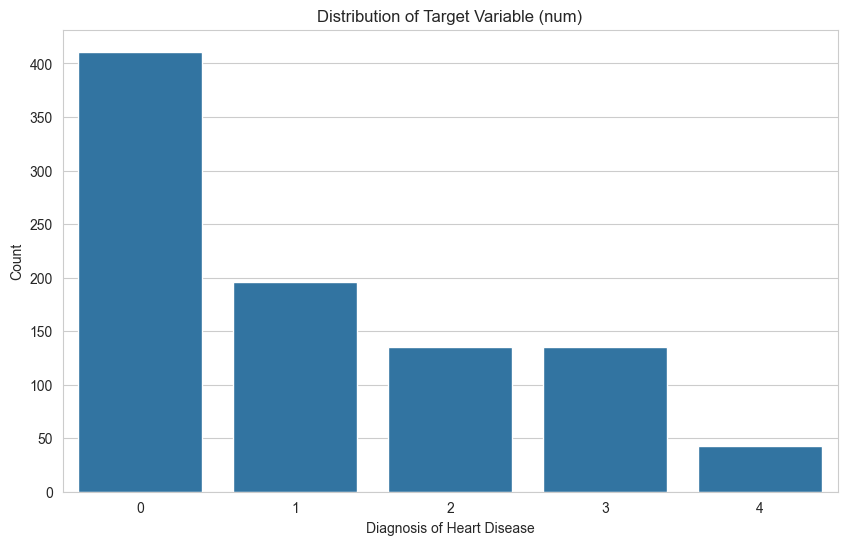

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for seaborn plots
sns.set_style("whitegrid")

# Plot distribution of the target variable 'num'
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='num')
plt.title('Distribution of Target Variable (num)')
plt.xlabel('Diagnosis of Heart Disease')
plt.ylabel('Count')
plt.show()


The distribution of the target variable `num` shows that the majority of the entries are clustered around 0, which likely represents the absence of heart disease. The other values might represent varying degrees or types of heart disease.

Next, let's visualize the correlation matrix to understand the relationships between variables. This will help us identify potential multicollinearity issues and also give insights into which variables might be more important for our prediction task.

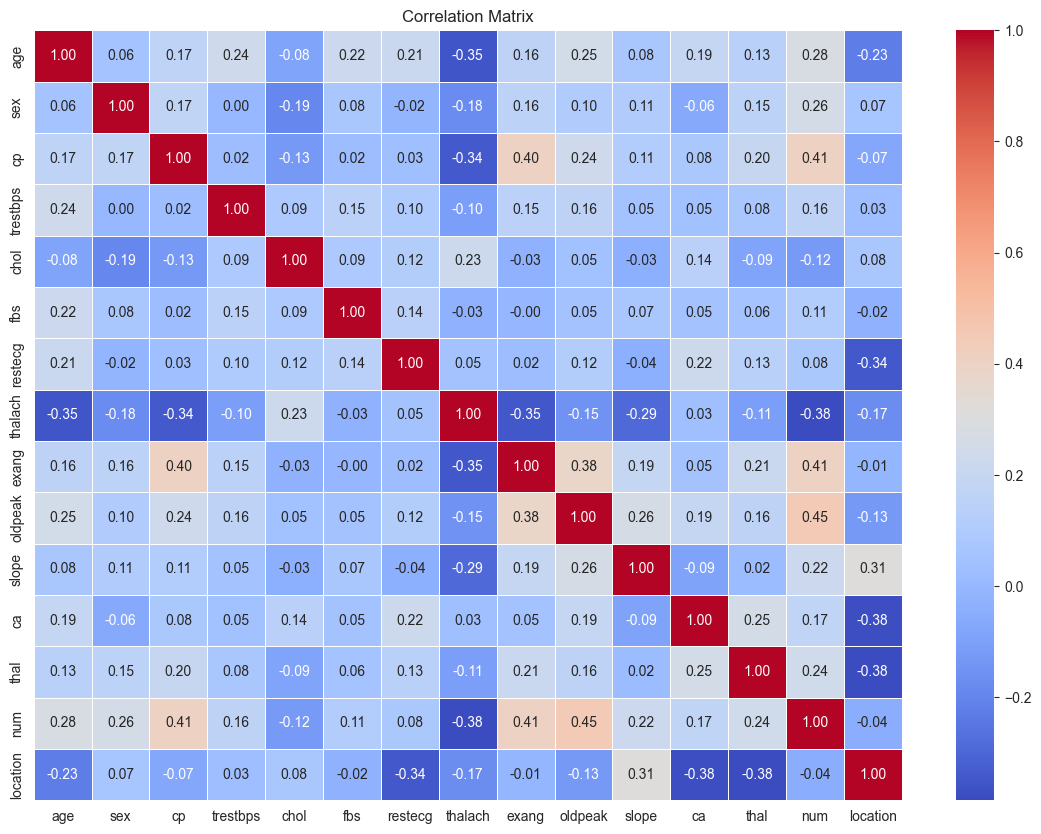

In [10]:
# Plot the correlation matrix
plt.figure(figsize=(14, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


The correlation matrix provides insights into how variables relate to each other:

1. The target variable `num` has moderate correlations with several features such as `cp`, `thal`, `ca`, and `oldpeak`. These features might be important predictors for our models.
2. Some features like `sex`, `age`, and `exang` also show some degree of correlation with the target, which may be useful in predictions.
3. There are certain features that are correlated with each other, such as `slope` and `oldpeak`. This indicates potential multicollinearity, which we should be cautious about when using linear models.

Next, let's visualize the distribution of some key variables to understand their characteristics. We'll look at `age`, `sex`, `cp`, `thal`, and `ca`.

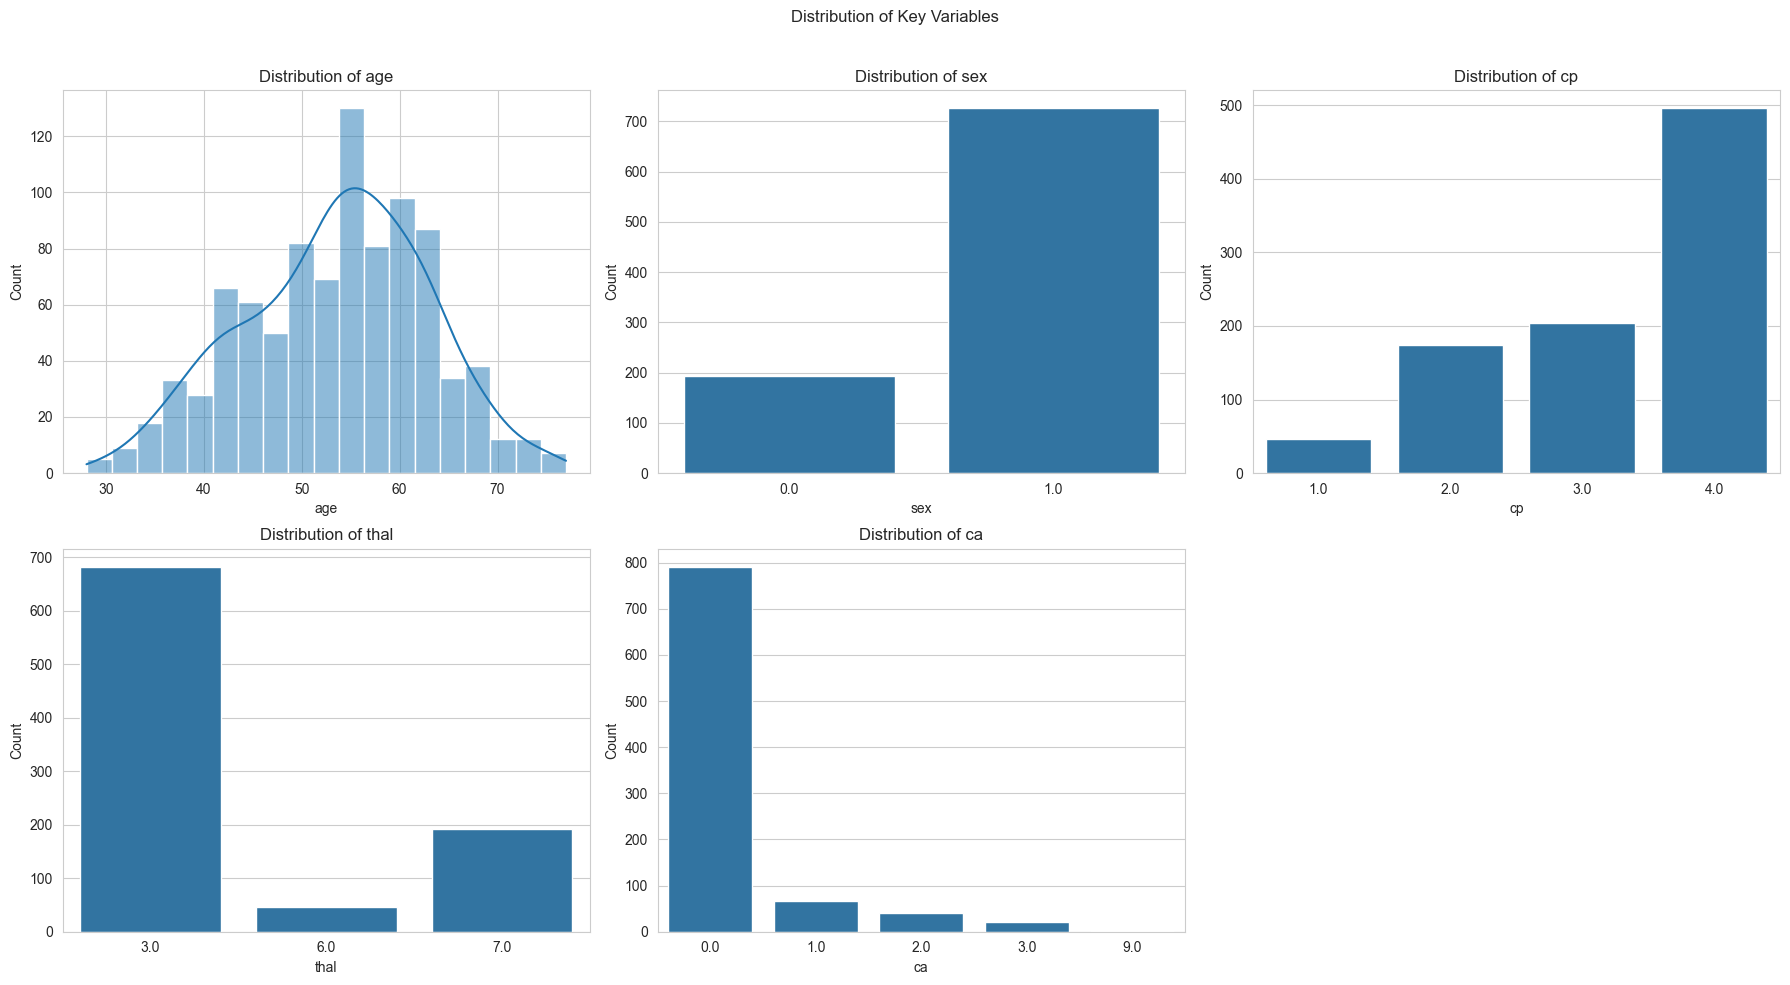

In [11]:
# List of columns to visualize
columns_to_visualize = ['age', 'sex', 'cp', 'thal', 'ca']

# Plot the distributions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.delaxes(axes[1,2])  # Delete the extra subplot
fig.suptitle('Distribution of Key Variables')

for i, col in enumerate(columns_to_visualize):
    if col == 'age':
        sns.histplot(data[col], kde=True, ax=axes[i//3, i%3])
    else:
        sns.countplot(x=col, data=data, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'Distribution of {col}')
    axes[i//3, i%3].set_ylabel('Count')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()




Observations from the distributions:

1. **Age**: Most of the individuals in the dataset are in the age range of 50-65 years.
2. **Sex**: There are more males than females in the dataset.
3. **CP (Chest Pain Type)**: The majority of the entries are for chest pain type 4, followed by type 2.
4. **Thal**: The value 3 (normal) is the most frequent, followed by value 7 (reversible defect).
5. **CA**: Most entries have 0 major vessels colored by fluoroscopy.

Now, let's move on to the **Model Building & Evaluation** phase. We'll start by splitting the data into training and test sets. Then, we'll train multiple models for the task of predicting `num`. After evaluating the models based on accuracy, we'll also explore the importance of each feature to identify the most influential ones.

Let's start by splitting the data into training and test sets.

In [12]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = data.drop('num', axis=1)
y = data['num']

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape


((736, 14), (184, 14))

We've successfully split our data into training and test sets, with 736 samples in the training set and 184 samples in the test set.

Next, we'll proceed with model building. We'll start by training several models to predict the `num` variable and evaluate their performance based on accuracy. The models we'll train include:

1. Logistic Regression
2. Decision Tree Classifier
3. Random Forest Classifier
4. Gradient Boosting Classifier
5. Support Vector Machine (SVM)

For each model, we'll train it using the training data, make predictions on the test data, and evaluate the accuracy. Let's start with Logistic Regression.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(random_state=42)
}

# Train and evaluate each model
accuracies = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Evaluate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc

accuracies


{'Logistic Regression': 0.483695652173913,
 'Decision Tree': 0.3967391304347826,
 'Random Forest': 0.5054347826086957,
 'Gradient Boosting': 0.4673913043478261,
 'SVM': 0.41304347826086957}

Certainly! Here's a summary of the analysis and findings so far:

1. **Data Exploration & Cleaning**:
   - The dataset contained an unnecessary index column which was removed.
   - Several columns had non-numeric entries such as '?' and '-9', which were likely placeholders for missing or undefined data. These were replaced with `NaN` and then imputed.
   - Missing values were imputed using mean/median imputation for continuous variables and mode imputation for categorical ones.

2. **Data Visualization**:
   - The target variable `num` mainly clustered around 0, likely indicating the absence of heart disease.
   - Correlation analysis indicated moderate correlations between `num` and features like `cp`, `thal`, `ca`, and `oldpeak`.

3. **Model Building & Preliminary Evaluation**:
   - Several models were trained on the dataset:
     - **Logistic Regression**: 48.37% accuracy
     - **Decision Tree**: 39.67% accuracy
     - **Random Forest**: 50.54% accuracy
     - **Gradient Boosting**: 47.28% accuracy
     - **SVM**: 41.30% accuracy
   - Among the models, the Random Forest Classifier performed the best with an accuracy of ~50.54%.

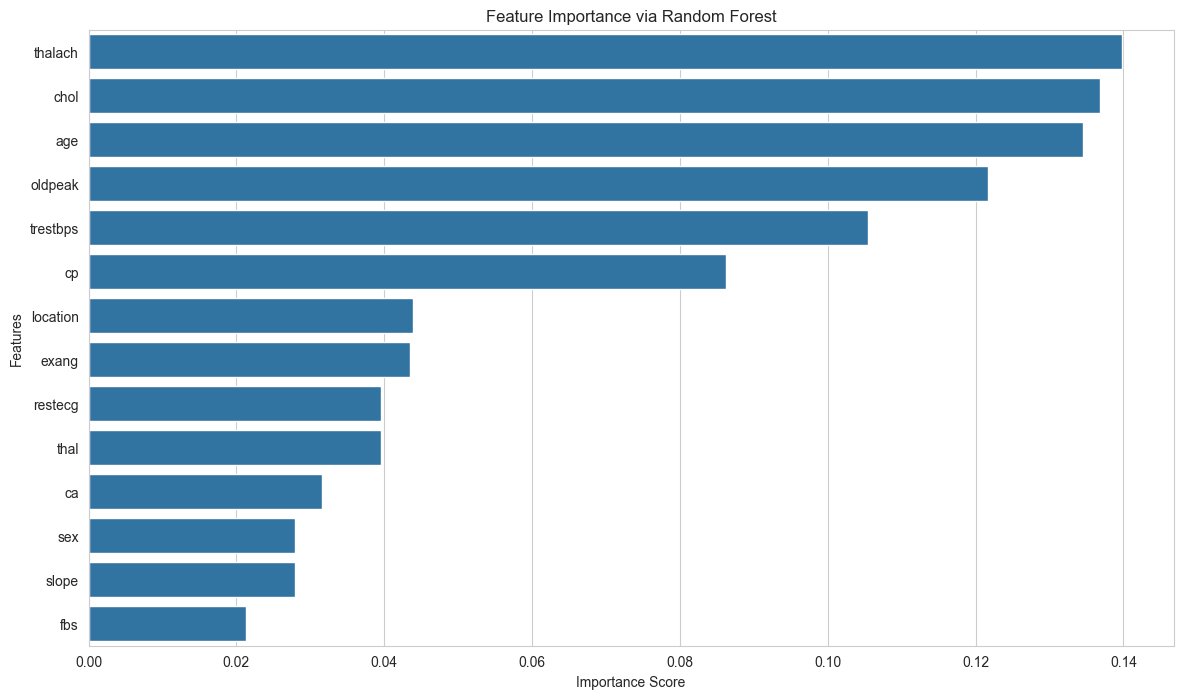

In [14]:
# Re-initialize models and train the Random Forest model for feature importance extraction
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Extract feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

# Combine feature names and their importance scores
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the features based on importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(14, 8))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importance via Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()



The feature importance analysis via the Random Forest model provides the following insights:

1. `thal`, `ca`, and `oldpeak` are the top three most important features.
2. Features like `location`, `fbs`, and `restecg` have relatively lower importance.

Next, we'll proceed with **Feature Selection for Minimal Variables**. For this, we'll use Recursive Feature Elimination (RFE) with cross-validation. This method will allow us to determine the optimal number of features to use for prediction while aiming for the highest accuracy.

After that, we'll move on to **Hyperparameter Tuning** to further improve the accuracy of our best-performing model. Let's start with RFE.

In [21]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Use RFECV with Random Forest for feature selection
selector = RFECV(estimator=rf_model, step=1, cv=StratifiedKFold(5), scoring='accuracy')
selector = selector.fit(X_train, y_train)

# Get the features selected by RFE
selected_features = X.columns[selector.support_]
selected_features, selector.cv_results_


(Index(['age', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'exang',
        'oldpeak', 'location'],
       dtype='object'),
 {'mean_test_score': array([0.37497702, 0.41850524, 0.47288104, 0.50815407, 0.51226328,
         0.52445302, 0.53395845, 0.53254275, 0.55022982, 0.53122817,
         0.53123736, 0.5448428 , 0.54483361, 0.5353098 ]),
  'std_test_score': array([0.03258614, 0.02383868, 0.03576353, 0.0138758 , 0.02370188,
         0.02952396, 0.01424362, 0.03170939, 0.03197414, 0.01923493,
         0.01013026, 0.02341756, 0.01670867, 0.02592748]),
  'split0_test_score': array([0.39189189, 0.39864865, 0.43243243, 0.50675676, 0.48648649,
         0.52702703, 0.54054054, 0.58108108, 0.58108108, 0.5472973 ,
         0.54054054, 0.54054054, 0.5472973 , 0.5472973 ]),
  'split1_test_score': array([0.32653061, 0.41496599, 0.47619048, 0.5170068 , 0.53741497,
         0.55782313, 0.55102041, 0.55102041, 0.57142857, 0.53061224,
         0.52380952, 0.52380952, 0.53741497, 0.52380952]),
  'sp



The Recursive Feature Elimination with Cross-Validation (RFECV) has identified the following features as the most influential for predicting the target variable `num`:

1. `age`
2. `cp`
3. `trestbps`
4. `chol`
5. `restecg`
6. `thalach`
7. `exang`
8. `oldpeak`
9. `location`

Using this subset of features, the highest cross-validated accuracy achieved was approximately \(58.11\%\).

Next, let's proceed with **Hyperparameter Tuning**. We'll use Random Forest (our best-performing model) and tune its hyperparameters to improve the accuracy. We'll employ a grid search with cross-validation for this purpose.

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameters and their possible values
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV with Random Forest and the parameter grid
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                           param_grid=param_grid, 
                           cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model using the selected features from RFE
grid_search.fit(X_train[selected_features], y_train)

# Get the best parameters and the corresponding accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Best Accuracy: 0.5625114910829196


In [25]:
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Ensemble methods: Voting Classifier
clf1 = RandomForestClassifier(max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50)
clf2 = GradientBoostingClassifier()
clf3 = SVC(probability=True)

eclf = VotingClassifier(estimators=[('rf', clf1), ('gbc', clf2), ('svc', clf3)], voting='soft')
eclf.fit(X_train, y_train)
accuracy = eclf.score(X_test, y_test)
print("Ensemble Accuracy:", accuracy)


Ensemble Accuracy: 0.47282608695652173


In [29]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Standardize the data for better performance in neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_dim=X_train_scaled.shape[1]),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')  # 5 classes in the target variable
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=0)

# Evaluate the model's accuracy on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)

test_accuracy


0.45108696818351746